# Мобильное приложение - выдление групп пользователей на основе поведения

## Введение

Имеются данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.
Необходимо выделить группы пользователей, которые различаются по метрикам:

* retention rate,
* время, проведённое в приложении, 
* частота действий, 
* конверсия в целевое действие — просмотр контактов.

А также проверить статистические гипотезы:
* пользователи, пришедшие из источников Yandex и Google демонстрируют разную конверсию в просмотры контактов
* по выходным выше частота совершения событий

**Цель исследования** - сегментировать пользователей и определить целевую группу для приложения, т.е. такую группу, которая имеет лучшие характеристики по удержанию, конверсии, частоте действий и времени, проведенном вприложении.  

Исследование пройдет в несколько этапов:
* предобработка данных
* исследовательский анализ
* сегментация пользователей
* проверка гипотез

Для анализа будут использованы библиотеки pandas, matplotlib, seaborn, stat.scipy.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от тимлида №1__


Цель так и не расписана
</div>

<div class="alert alert-info"> <b>Комментарии студента:</b> Добавила формулировку цели.</div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №2__


Отличная практика - расписывать цель и основные этапы перед началом проекта

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import plotly.express as px
import scipy.stats as st
import math as mth


In [2]:
# Загрузим данные и посмотрим на них.
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
display(mobile_sources.sample(10))
mobile_dataset.sample(10)

,userId,source
2885,543f1bc6-c773-46d1-af50-a6d8eaa3a620,other
1030,1e6d9849-f287-464c-b0db-555132d7d5c8,yandex
905,d33704b1-1990-4463-980b-052049ec4a01,other
162,063c0b06-6d9d-4580-8d03-f1c8f19ebfa1,other
3868,cdfe7920-2788-4431-8645-377d8bdab8ae,other
1305,0dc81967-5326-43f0-989a-8ca9535fd4d0,yandex
2706,41dcb512-6f37-436a-b973-2a978f6b8e2e,google
3036,369f958d-9749-4bd3-aa74-41d7bdee46c4,google
352,43e3b0f3-87ac-4b10-905b-dc7b4cabca4d,other
3206,60b03b2c-18df-42d8-af5f-ffd2c405f7fb,yandex


,event.time,event.name,user.id
48745,2019-10-25 23:00:56.662152,tips_show,cd5e284d-703b-4362-939b-9f8d945a6dd6
23314,2019-10-16 17:11:02.890408,contacts_show,7f38ea5d-ad7c-4e8a-b1e1-c63da89a4c4c
25523,2019-10-17 14:28:09.788363,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b
60586,2019-10-29 21:04:35.990212,tips_show,fd33e787-85c8-4c53-99bd-3439f676fb40
35287,2019-10-21 14:24:02.236066,tips_show,76d06bf1-e869-4ba1-92fb-4684fb258f9f
2343,2019-10-07 23:18:59.277959,tips_show,764c262d-9002-4965-9988-4d47718bf1b5
24354,2019-10-17 02:46:34.590612,tips_show,e56ce3e5-c8c5-460d-815e-457f215947da
44691,2019-10-24 15:32:39.491636,tips_show,86c85ca1-0293-478a-8a4c-7d17b679579d
62265,2019-10-30 14:17:27.727962,tips_show,62e054da-d871-4153-a76c-1e03093140b1
34841,2019-10-21 12:15:10.858578,contacts_show,e38cb669-7335-4d56-9de5-c8d5d2f13fd3


In [3]:
mobile_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [4]:
# Посмотрим, какие источники есть в нашем датасете.
mobile_sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [5]:
# Для удобства переименуем столбец.
mobile_sources = mobile_sources.rename(columns={'userId':'user_id'})

In [6]:
# Посмотрим, сколько уникальных пользователей содержится в датасете с источниками.
len(mobile_sources['user_id'].unique())

4293

In [7]:
# Проверим на дубликаты.
mobile_sources.duplicated().sum()

0

In [8]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [9]:
# Также переименуем столбцы.
mobile_dataset = mobile_dataset.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})

In [10]:
# Посмотрим на столбец названиями событий.
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [11]:
# Переименуем однотипные названия.
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('show_contacts', 'contacts_show')
mobile_dataset['event_name'] = (mobile_dataset['event_name']
                                .replace(['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'],
                                         'search'))

In [12]:
# Приведем столбец с датой и временем к соответствующему типу, так же округлим значения до секунд.
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time']).dt.round('S')

In [13]:
mobile_dataset.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [14]:
# Проверим датасет на дубликаты.
mobile_dataset.duplicated().sum()

1190

In [15]:
mobile_dataset = mobile_dataset.drop_duplicates()

In [16]:
# Посморим, сколько уникальных пользователей содержится в датасете.
len(mobile_dataset['user_id'].unique())

4293

In [17]:
# Посмотрим минимальные и макисмальные даты.
print('Минимальная дата', mobile_dataset['event_time'].min())
print('Максимальная дата', mobile_dataset['event_time'].max())

Минимальная дата 2019-10-07 00:00:00
Максимальная дата 2019-11-03 23:58:13


По результатам предобработки оба имеющиеся датасета проверены на пропуски и дубликаты, в mobile_dataset удалены дубликаты. В mobile_source изменен заголовок столбца. В mobile_dataset также изменены названия столбцов на более удобные, заменены значения в столбце event.name - 'show_contacts' на 'contacts_show', все названия событий, содержащие 'search' заменены на просто 'search'. Столбец с датой и временем приведен к соответствующему типу.

Уникальное количество пользователей в обоих датасетах совпадает - 4293.

## Исследовательский анализ данных.

In [18]:
# Перед началом анализа, объединим данные двух датасетов и отсортируем его по пользователю и 
# времени для корректного расчета сессий.
data = (mobile_dataset
        .merge(mobile_sources, on='user_id', how='left')
        .sort_values(['user_id', 'event_time']))
data.sample(5)

,event_time,event_name,user_id,source
9686,2019-10-11 11:58:21,tips_show,68c94835-e896-4d48-a2c0-3c3226cec629,yandex
54183,2019-10-28 10:21:01,map,a83c2011-d536-4c57-8841-d1b6aefd6311,yandex
23350,2019-10-16 20:33:41,tips_show,8270324d-d1ec-49cf-ad44-a4d3edc40f93,google
32723,2019-10-20 17:11:55,tips_show,f7f350e6-ce05-45b3-97d1-fe9cc369f388,yandex
64115,2019-10-31 14:01:11,tips_show,197e9e80-cabf-44a6-ac16-ed303d665261,yandex


Для дальнейшего анализа необходимо по имеющимся данным выделить сессии пользователей. Мне кажется логичным для отделения одной сессии от другой взять период 30 минут, т.к. если пользователь не взаимодействует с приложением некоторое время, то скорее всего при следующем обращении к приложению он начнет все действия с начала.

In [19]:
# Создадим столбец с номером id сессии, время ожидания сессии зададим 30 минут.
g = (data.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
data['session_id'] = data.groupby(['user_id', g], sort=False).ngroup() + 1
data.head(15)

,event_time,event_name,user_id,source,session_id
795,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
796,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
799,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
810,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
818,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
819,2019-10-07 13:45:43,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
820,2019-10-07 13:46:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
824,2019-10-07 13:47:33,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
827,2019-10-07 13:49:42,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
6466,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2


In [20]:
# Посмотрим на общее количество уникальных сессий
len(data['session_id'].unique())

10368

In [21]:
# Добавим столбец со временем начала каждой сессии.
data = data.merge((data.groupby(['user_id', 'session_id'])
                .agg({'event_time':'first'})
                .rename(columns={'event_time':'session_start'})
                .reset_index()), on=['user_id', 'session_id'], how='left')
data.head()

,event_time,event_name,user_id,source,session_id,session_start
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:46
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:46
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:46
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:46
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,2019-10-07 13:39:46


In [22]:
# Создадим таблицу с уникальными парами пользователь-начало сессии.
data_sessions = data.groupby(['user_id', 'session_start'])['event_name'].count().reset_index()
data_sessions

,user_id,session_start,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,9
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09 18:33:56,4
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21 19:52:31,14
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:18:15,8
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,9
...,...,...,...
10363,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02 01:16:49,1
10364,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02 18:01:27,2
10365,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02 19:25:54,4
10366,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03 14:32:56,15


In [23]:
# Посмотрим среднее количество событий за сессию.
print('Медианное количество действий за сессию', data_sessions['event_name'].median())
print('Среднее количество действий за сессию', round(data_sessions['event_name'].mean()))
print('Максимальное количество действий за сессию', data_sessions['event_name'].max())
print('Минимльное количество действий за сессию', data_sessions['event_name'].min())

Медианное количество действий за сессию 4.0
Среднее количество действий за сессию 7
Максимальное количество действий за сессию 149
Минимльное количество действий за сессию 1


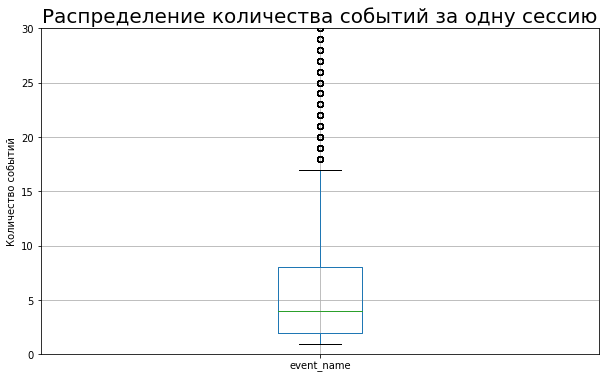

In [24]:
plt.figure(figsize=(10,6))
data_sessions.boxplot()
plt.title('Распределение количества событий за одну сессию',fontsize=20)
plt.ylabel('Количество событий')
plt.ylim(0,30)
plt.show()

Медианное количество событий за сессию - 4, при этом пользователи редко совершают более 17 событий за раз.

### Retention Rate


In [25]:
# Теперь можно приступать к созданию профилей пользователей c датой первого посещения
profiles = (data.groupby('user_id')
                .agg({'event_time':'first', 'source':'first'})
                .rename(columns={'event_time':'first_ts'})
                .reset_index())
profiles['first_dt'] = profiles['first_ts'].dt.date
profiles['is_contacts_show'] = profiles['user_id'].isin(data.query('event_name == "contacts_show"')['user_id'].unique())

profiles 

,user_id,first_ts,source,first_dt,is_contacts_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,other,2019-10-07,False
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,yandex,2019-10-19,True
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,yandex,2019-11-01,False
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,google,2019-10-18,False
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,yandex,2019-10-25,True
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,yandex,2019-10-13,False
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,yandex,2019-10-07,True
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,google,2019-10-23,False
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:34,yandex,2019-10-21,True


In [26]:
# Напишем функицю для расчета удержания, в тело функции заранее включим разделение пользователей на просмотревших и
# не просмотревших контакты.
def get_retention(
    profiles,
    data,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец is_contacts_show в передаваемый dimensions список
    dimensions = ['is_contacts_show'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(data_sessions[['user_id', 'session_start']], on='user_id', how='left')
    
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [27]:
# Функция для сглаживания данных для графиков истории изменения.
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [28]:
# Функция для визуализации удержания.
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'is_contacts_show'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('is_contacts_show == True').droplevel('is_contacts_show').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей, просмотревших контакты')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('is_contacts_show == False').droplevel('is_contacts_show').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей, не просмотревших контакты')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['first_dt', 'is_contacts_show']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('is_contacts_show == True').pivot_table(
        index='first_dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей, просмотревших контакты, на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('is_contacts_show == False').pivot_table(
        index='first_dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей, не просмотревших контакты, на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

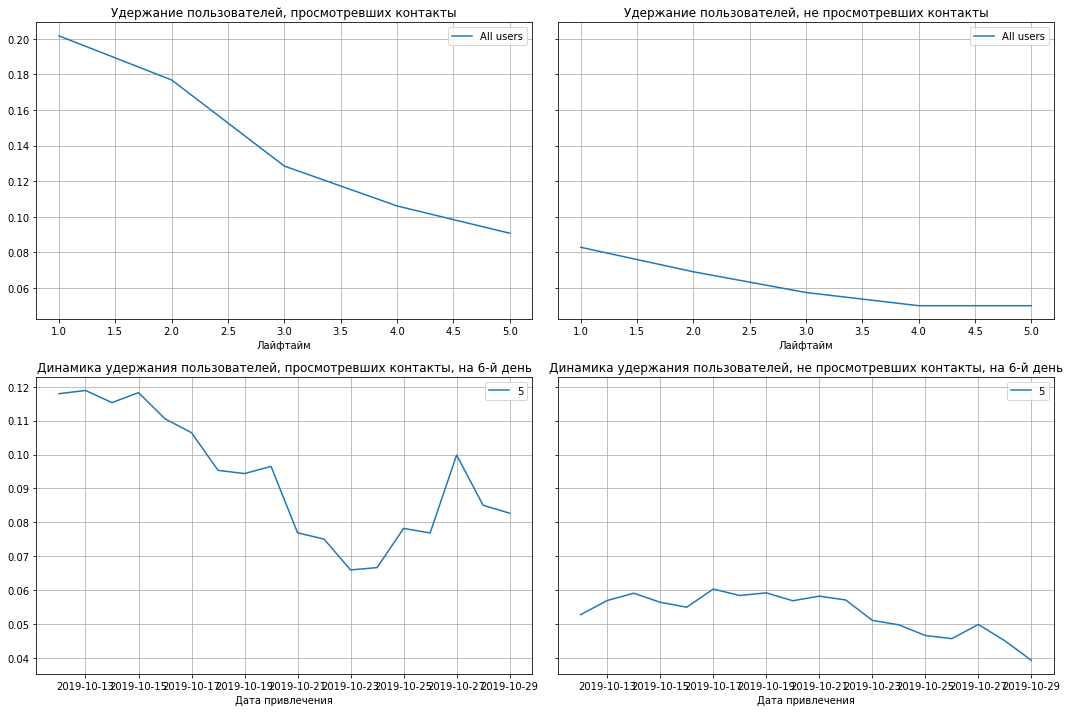

In [29]:
# Посмотрим на удержание пользователей.
# За момент анализа примем последний день наблюдения. Горизонт - неделя, т.к. у нас имеются данные за 28 дней
observation_date = datetime(2019, 11, 3).date()
analysis_horizon = 6

retention_raw, retention, retention_history = get_retention(profiles, data, observation_date, analysis_horizon)

plot_retention(retention, retention_history, analysis_horizon, window=6)

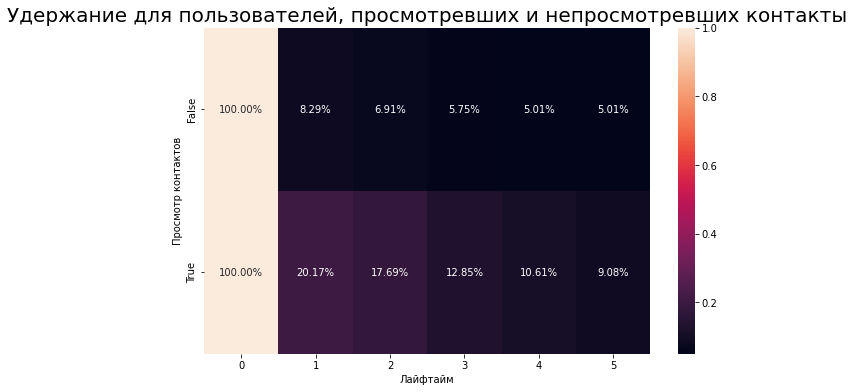

In [30]:
# Посмотрим на удержание на хитмэпе.
plt.figure(figsize=(10,6))
sns.heatmap(
    retention.drop(columns=['cohort_size']),
    annot=True,
    fmt='.2%')
plt.title('Удержание для пользователей, просмотревших и непросмотревших контакты',fontsize=20)
plt.ylabel('Просмотр контактов')
plt.xlabel('Лайфтайм')
plt.show()

Удержание пользователей, просмотревших контакты, ожидаемо выше, чем у непросмотревших - удержание шестого дня упросмотревших контакты выше, чем удержаниенепросмотревших второго дня. Заметим, что удержание, среди просмотревших контакты, начинает резко падать с 16 по 24 октября. Видимо, в этот период что-то произошло с приложением. Возможно, какой-то технический сбой.

Среди пользователей, непросматривающих контакты, динамика удержание выглядит стабильнее, но заметим, что она начинает заметно снижаться с 24 октября. Возможно, в приложении что-то изменилось, что стало неудобным для пользователей.

### Конверсия

In [31]:
contacts_shows = (data
                 .query('event_name == "contacts_show"')[['user_id', 'event_time']]
                 .sort_values(by=['user_id', 'event_time']))

contacts_shows.head()

,user_id,event_time
50,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:17:19
54,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:23:12
56,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 19:30:32
60,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20 20:04:53
78,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29 21:26:40


In [32]:
# Функция для расчета конверсии.
def get_conversion(
    profiles,
    shows,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_shows = (
        shows.sort_values(by=['user_id', 'event_time'])
        .groupby('user_id')
        .agg({'event_time': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_shows[['user_id', 'event_time']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [33]:
# Функция для визуализации конверсии.
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['first_dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='first_dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

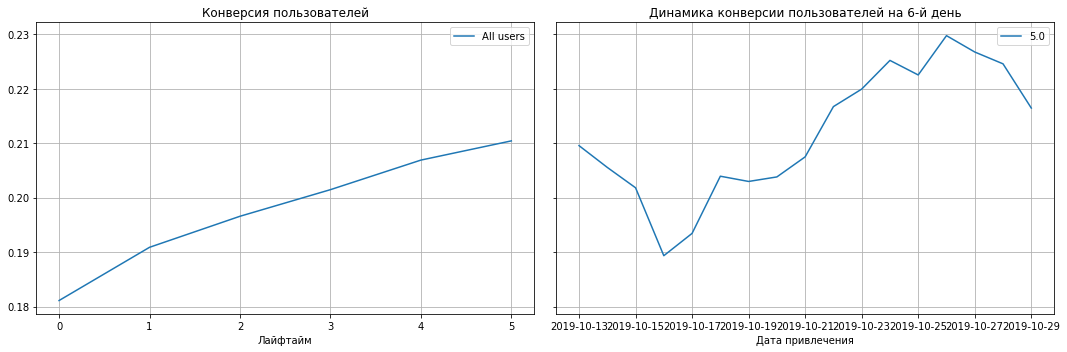

In [34]:
# Сначала посмотрим на конверсию в целом.
dimensions = []
conversion_raw, conversion, conversion_history = get_conversion(profiles, contacts_shows, 
                                                                observation_date, analysis_horizon, dimensions=dimensions)
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

In [35]:
# Посмотримтакжена конверсию в целом.
print('Общая конверсия', round(len(profiles.query('is_contacts_show == True')) / len(profiles), 3))

Общая конверсия 0.229


Конверсия в просмотр контактов в целом попроекту 22,9%, т.е. из всех пользователей приложения целевое действие в целом совершили 22,9%.

Конверсия плавно растет, на графике динамики видно падение конверсии для пользователей, привлеченных с 13-15 октября, конверсия для пользователей, пришедших позже, выше.

### Частота совершения событий

In [36]:
# Посмотрим на количество событий по источникам.
data['event_dt'] = data['event_time'].dt.date
events = (data
          .groupby('event_name')
          .agg({'event_time':'count'})
          .sort_values(by='event_time', ascending=False)
          .reset_index())



In [50]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
fig = px.bar(events, x='event_name', y='event_time')
fig.update_layout(title=dict(text='Количество событий',font=dict(size=20), x=0.45),
                  xaxis_title='Название события',
                  yaxis_title='Количество событий')
fig.show('png')

ValueError: ignored

Больше всего происходит событие tips_show, количество этих событий в разы превышает все остальные. Далее следует photos_show, search и advert_open. Меньше всего событий contacts_call - очевидно, пользователи предпочитают после просмотра контактов связываться самостоятельно, а не через приложение. Также очень мало событий tips_click - похоже, что рекомендованные приложением объявления не пользуются популярностью.

In [ ]:
# Посмотрим на количество событий по датам.
# Подготовим данные.
data['event_dt'] = data['event_time'].dt.date
data['weekday'] = data['event_time'].dt.weekday

events_by_dt = (data
                   .groupby('event_dt')
                   .agg({'event_time':'count'})
                   .sort_values(by='event_time', ascending=False)
                   .reset_index())

In [ ]:
fig = px.bar(events_by_dt, x='event_dt', y='event_time')
fig.update_layout(title=dict(text='События по датам',font=dict(size=20), x=0.45),
                  xaxis_title='Дата',
                  yaxis_title='Количество событий')
fig.show()

На графике не наблюдается никакой закономерности в количестве событий по разным датам. Заметно, что в некоторые дни событий гораздо меньше. Проверим, не связано ли это с выходными.

In [ ]:
# Посмотрим на события по дням недели.
events_by_weekday = (data
                   .groupby('weekday')
                   .agg({'event_time':'count'})
                   .sort_values(by='event_time', ascending=False)
                   .reset_index())

In [ ]:
fig = px.bar(events_by_weekday, x='weekday', y='event_time')
fig.update_layout(title=dict(text='События по дням недели',font=dict(size=20), x=0.45),
                  xaxis_title='День недели',
                  yaxis_title='Количество событий')
fig.show()

Больше всего событий происходит в понедельник, далее количество событий убыват к концу недели и меньше всего их происходит в пятницу и субботу. Похоже, пользователи предпочитают отдыхать в выходные, а не заниматься делами.

### Время, проведенное в приложении

In [ ]:
session_times = (data
                 .pivot_table(index=['user_id', 'session_id'],
                              values='event_time', 
                              aggfunc=['first', 'last'])
                 .reset_index())
session_times['duration'] = round((session_times['last'] - session_times['first']).astype('timedelta64[s]') / 60, 2)

session_times.head()

,user_id,session_id,first,last,duration
,,,event_time,event_time,
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:46,2019-10-07 13:49:42,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:56,2019-10-09 18:42:23,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:31,2019-10-21 20:07:30,14.98
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:15,2019-10-22 11:30:53,12.63
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,2019-10-19 21:34:34,2019-10-19 21:59:55,25.35


In [ ]:
print(f'Медианное время сессии', session_times['duration'].median(), 'минут')
print('Среднее время сессии', round(session_times['duration'].mean(), 2), 'минут')
print('Максимальное время сессии', session_times['duration'].max(), 'минут')
print('Минимальное время сессии', session_times['duration'].min(), 'минут')

Медианное время сессии 5.58 минут
Среднее время сессии 12.88 минут
Максимальное время сессии 321.97 минут
Минимальное время сессии 0.0 минут


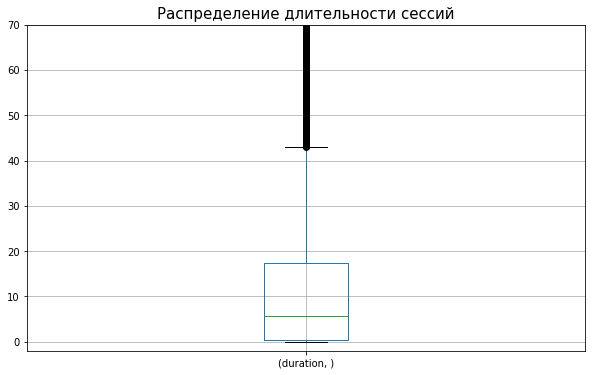

In [ ]:
plt.figure(figsize=(10,6))
session_times[['user_id', 'duration']].boxplot()
plt.title('Распределение длительности сессий', fontsize=15)
plt.ylim(-2, 70)
plt.show()

In [ ]:
# Посмотрим внимательнее на нулевые сессии.
zero_sessions = session_times.loc[session_times['duration'] == 0].merge(data[['event_name','session_id']],
                                                                        on='session_id', how='left')
zero_sessions = zero_sessions[['session_id', 'event_name']]
zero_sessions

<ipython-input-45-cbf13fa726ea>:2: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)



,session_id,event_name
0,10,contacts_show
1,20,photos_show
2,27,contacts_show
3,34,contacts_show
4,43,map
...,...,...
2138,10331,tips_show
2139,10342,tips_show
2140,10343,tips_show
2141,10362,tips_show


In [ ]:
zero_sessions['event_name'].unique()

array(['contacts_show', 'photos_show', 'map', 'tips_show', 'search',
       'favorites_add', 'advert_open', 'tips_click', 'contacts_call'],
      dtype=object)

In [ ]:
zero_sessions.groupby('event_name').agg({'session_id':'count'}).sort_values(by='session_id', ascending=False)

,session_id
event_name,
tips_show,899
photos_show,554
search,378
contacts_show,125
map,100
advert_open,46
favorites_add,30
tips_click,10
contacts_call,1


In [ ]:
# Посмотрим, какую долю от всех сессий составляют нулевые.
round(len(zero_sessions) / len(session_times), 3)

0.207

В датасете присутствует большое количество нулевых сессий - 20,7% от всех сессий, причем в нулевых сессиях имеются события всех типов. Структура количества событий в нулевых сессия совпадает с общей структурой количества событий. Это выглядит странно, возможно у пользователей происходил какой-то сбой в приложении. 

Сессии больше 40 минут нетипичны и их можно отнести к выбросам.

Медианная продолжительность сессии - 5,58 минут.

Средняя продолжительность сессии - 12,88 минут.

Такая разница между средним и медианным временем скорее всего произошла из-за наличия выбросов.

 **Общий вывод по исследовательскому анализу данных**
 
 По датасету сформированы сессии с таймаутом 30 минут.
 Медианное количество событий за сессию - 4, обычно пользователи совершают не более 17 событий за сессию.
 
 Удержание, ожидаемо, лучше среди пользователей, просмотревших контакты. К 6-му дню у этой категории пользователей удержание достигает 9,08%, среди непросмотревших контакты - 5,01%. При этом у просмотревших контакты резко падает удержание пользователей, привлеченных с 16 по 24 октября.
 
 Общая конверсия составляет 22,9%. При рассмотрении динамики конверсии по датам привлечения заметно ее резкоепадение с 13 по 15 октября.
 
 Самое частое событие - показ рекомендованных объявлений, но пользователи довольно редко кликают по ним. Меньше всего событий совершаетсяв пятницу и субботу, скорее всего пользователи предпочитают отдыхать в выходные. В понедельник количество событий резко возрастает и плавно снижается к концу недели.
 
 Медианное время в приложении - 5,58 минут, пользователи редко проводят в приложении более 42 минут. Также имеется большое количество нулевых сессий, которые содержат все имеющиеся типы действий.
 
 Принимая во внимание снижение удержания пользователей, привлеченных в определенные даты и странные нулевые сессии, можно предположить какой-то сбой приложении.

## Сегментация

Я считаю, что имеет смысл сегментировать пользователей по источнику.
При таком подходе можно посмотреть, сколько всего пользователей приходит в приложении из конкретного источника. Это поможет понять, приходит больше пользователей, совершающих целевое действие - просмотр контактов.
А также можно определить, где и какая реклама приложения лучше работает, скорректировать ее или оптимизировать рекламные расходы.


In [ ]:
data.groupby('source').agg({'user_id':'nunique'})

,user_id
source,
google,1129
other,1230
yandex,1934


## Ответы на вопросы пользователей

### Retention Rate по сегментам

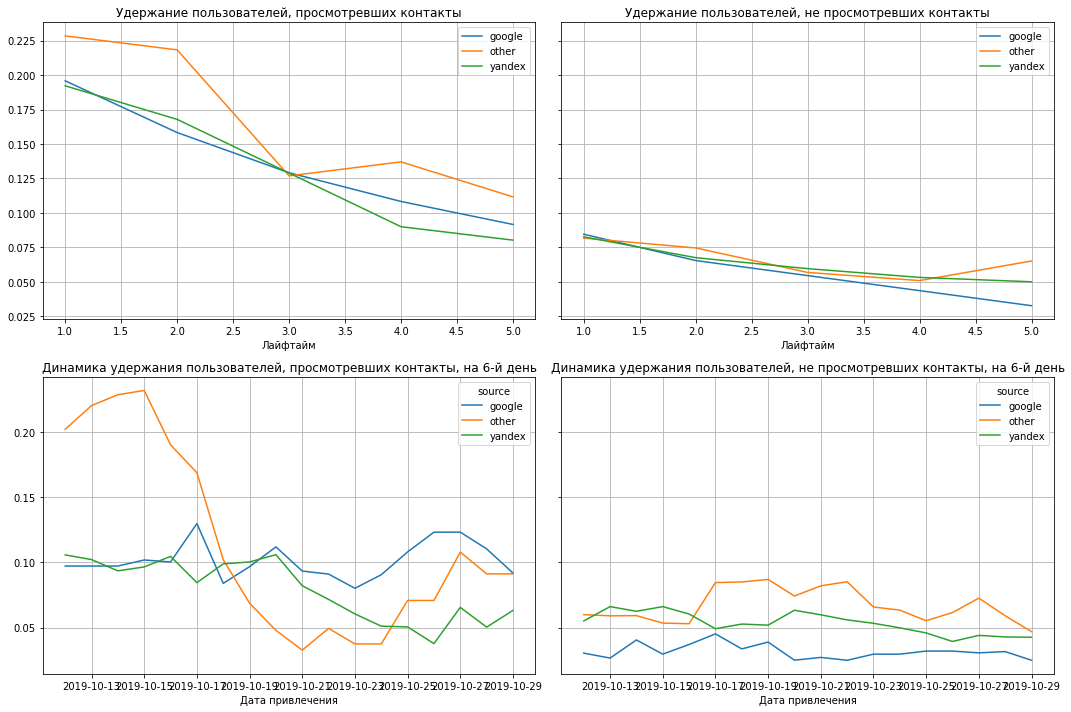

In [ ]:
# Посмотрим на удержание пользователей по источникам.
observation_date = datetime(2019, 11, 3).date()
analysis_horizon = 6
dimensions = ['source']
retention_raw, retention, retention_history = get_retention(profiles, data, observation_date,
                                                            analysis_horizon, dimensions=dimensions)

plot_retention(retention, retention_history, analysis_horizon, window=6)

Для просмотревших контакты лучше всего удерживаются пользователи из источника "Другие", источники Google и Yandex примерно на одном уровне, но после 3-го лайфтайма удержание источника Google выглядит лучше. Динамика показывает резкое падение удержания пользователей из источника "Другие" привлеченных с 14 по 24 октября и из источника Yandex с 20 октября. 

Для пользователей, непросмотревших контакты, удержание стабильно для всех источников. На графике динамики самое высокое удержание показывают пользователи, привлеченные из источника "Другие".

### Конверсия по сегментам

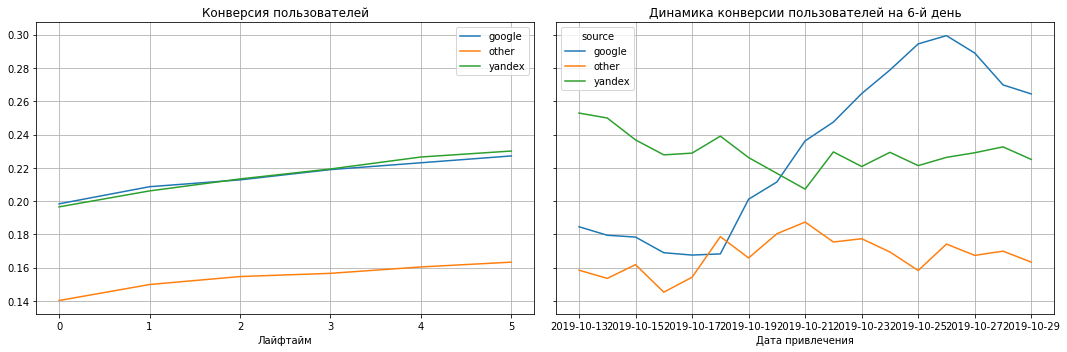

In [ ]:
# Посмотрим конверсию в разрезе источников.
dimensions = ['source']
conversion_raw, conversion, conversion_history = get_conversion(profiles, contacts_shows, 
                                                                observation_date, analysis_horizon, dimensions=dimensions)
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

In [ ]:
print('Общая конверсия по источнику Google', round(len(profiles.query('is_contacts_show == True & source == "google"')) 
                               / len(profiles.query('source == "google"')), 3))
print('Общая конверсия по источнику Yandex', round(len(profiles.query('is_contacts_show == True & source == "yandex"')) 
                               / len(profiles.query('source == "yandex"')), 3))
print('Общая конверсия по источнику "Другие"', round(len(profiles.query('is_contacts_show == True & source == "other"')) 
                               / len(profiles.query('source == "other"')), 3))

Общая конверсия по источнику Google 0.244
Общая конверсия по источнику Yandex 0.247
Общая конверсия по источнику "Другие" 0.185


Конверсия из источников Google и Yandex примерно на одном уровне и значительно выше конверсии источника "Другие".
В динамике видно, что конверсия  из источника Google резко растет для пользователей, привлеченных после 18 октября.

### События по сегментам

In [ ]:
events_seg = (data
          .groupby(['source','event_name'])
          .agg({'event_time':'count'})
          .sort_values(by='event_time', ascending=False)
          .reset_index())

In [ ]:
fig = px.bar(events_seg, x='event_name', y='event_time', color='source')
fig.update_layout(title=dict(text='Количество событий по сегментам',font=dict(size=20), x=0.45),
                  xaxis_title='Название события',
                  yaxis_title='Количество событий')
fig.show()

In [ ]:
events_by_dt_seg = (data
                   .groupby(['source', 'event_dt'])
                   .agg({'event_time':'count'})
                   .sort_values(by='event_time', ascending=False)
                   .reset_index())

In [ ]:
fig = px.bar(events_by_dt_seg, x='event_dt', y='event_time', color='source')
fig.update_layout(title=dict(text='События по датам и сегментам',font=dict(size=20), x=0.45),
                  xaxis_title='Дата',
                  yaxis_title='Количество событий')
fig.show()

In [ ]:
events_by_weekday_seg = (data
                   .groupby(['source','weekday'])
                   .agg({'event_time':'count'})
                   .sort_values(by='event_time', ascending=False)
                   .reset_index())

In [ ]:
fig = px.bar(events_by_weekday_seg, x='weekday', y='event_time', color='source')
fig.update_layout(title=dict(text='События по дням недели',font=dict(size=20), x=0.45),
                  xaxis_title='День недели',
                  yaxis_title='Количество событий')
fig.show()

Больше всего событий совершают пользователи из источника Yandex - в целом и в разбивке по датам и дням недели. Пользователи из источников "Другие" и Google совершают примерно одинаковое количество событий.

### Длительность сессий по сегментам

In [ ]:
session_times_seg = (data
                 .pivot_table(index=['source','user_id', 'session_id'],
                              values='event_time', 
                              aggfunc=['first', 'last'])
                 .reset_index())
session_times_seg['duration'] = round((session_times_seg['last'] - session_times_seg['first']).astype('timedelta64[s]')
                                      / 60, 2)

session_times_seg.head()

,source,user_id,session_id,first,last,duration
,,,,event_time,event_time,
0,google,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,12,2019-10-18 22:14:06,2019-10-18 22:17:41,3.58
1,google,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,13,2019-10-20 17:47:19,2019-10-20 17:48:42,1.38
2,google,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,14,2019-10-25 22:17:32,2019-10-25 22:45:50,28.30
3,google,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,15,2019-10-26 23:34:22,2019-10-27 00:12:12,37.83
4,google,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,16,2019-10-27 20:18:09,2019-10-27 20:18:27,0.30


In [ ]:
(session_times_seg
 .pivot_table(index='source', values='duration', aggfunc=['median', 'mean', 'min', 'max'])
 .sort_values(by='median', ascending=False))

,median,mean,min,max
,,,,
source,,,,
yandex,6.70,14.062843,0.0,259.48
google,5.85,13.107910,0.0,217.50
other,3.95,10.885545,0.0,321.97


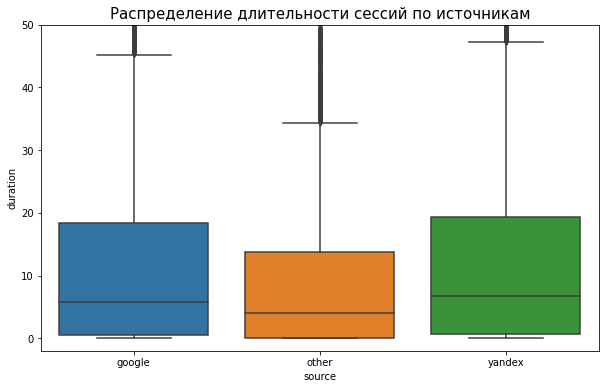

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='source', y='duration', data=session_times_seg)
plt.title('Распределение длительности сессий по источникам', fontsize=15)
plt.ylim(-2, 50)
plt.show()

In [ ]:
df = (session_times_seg
 .pivot_table(index='source', values='duration', aggfunc=['median', 'mean', 'min', 'max'])
 .sort_values(by='median', ascending=False).reset_index())
fig = px.bar(df, x='source', y='median')
fig.update_layout(title=dict(text='Медианная длительность сессий по источникам привлечения',font=dict(size=20), x=0.45),
                  xaxis_title='Источник',
                  yaxis_title='Минуты')
fig.show()

Самые большие медианные сессии у пользователей из источника Yandex. Самые короткие медианные сессии у "Других",  также большое количество нулевых сессий именно у источника "Другие".

## Гипотезы

### Гипотеза 1. Пользователи, пришедшие из источников Google и Yandex, показывают разную конверсию в просмотр контактов.



Н0: Между конверсией пользователей из источников Google и Yandex нет значимых различий.

Н1: Различия есть.

Зададим **уровень значимости 0,05**.

Для оценки различий воспользуемся тестом Манна-Уитни.


In [ ]:
# Подготовим данные для применения статистического теста. Создадим выборки с количеством сессий для пользователей, 
# просмотревших контакты.
google_shows = (data.query('source == "google" & event_name == "contacts_show"')
                    .groupby('user_id', as_index=False)
                    .agg({'session_id':'nunique'})
                    .rename(columns={'session_id':'sessions'}))
yandex_shows = (data.query('source == "yandex" & event_name == "contacts_show"')
                    .groupby('user_id', as_index=False)
                    .agg({'session_id':'nunique'})
                    .rename(columns={'session_id':'sessions'}))

# Создадим выборки с количестовм заказов для всех пользователей, пользователям, которые ничего не заказали поставим 0.
google_sample = pd.concat([google_shows['sessions'],
                           pd.Series(0, index=np.arange(len(mobile_sources.query('source == "google"')) - len(google_shows)),
                              name = 'sessions')], axis=0)
yandex_sample = pd.concat([yandex_shows['sessions'],
                           pd.Series(0, index=np.arange(len(mobile_sources.query('source == "yandex"')) - len(yandex_shows)),
                              name = 'sessions')], axis=0)

# Применим U-критерий Манна-Уитни
print('p_value: {0:.3f}'.format(st.mannwhitneyu(google_sample, yandex_sample)[1]))

p_value: 0.994


p-value больше заданного уровня значимости, принимаем нулевую гипотезу. У нас есть основания считать, что между группами нет статистически значимого различия в конверсии.

In [ ]:
# Посмотрим как отличаются между собой средние количества заказов.
print('{0:.3f}'.format(yandex_sample.mean() / google_sample.mean() - 1))

-0.150


Количество просмотров контактов среди пользователей из источника Google меньше, чем среди пользователей из источника Yandex на 15%.

In [ ]:
# Проверим, пересекаются ли пользователи из источников Google и Yandex.
google_users = data.query('source == "google"')['user_id'].unique()
data.query('source == "yandex" & user_id in @google_users')

,event_time,event_name,user_id,source,session_id,session_start,event_dt,weekday


In [ ]:
print('Общая конверсия по источнику Google', round(len(profiles.query('is_contacts_show == True & source == "google"')) 
                               / len(profiles.query('source == "google"')), 3))
print('Общая конверсия по источнику Yandex', round(len(profiles.query('is_contacts_show == True & source == "yandex"')) 
                               / len(profiles.query('source == "yandex"')), 3))
print('Общая конверсия по источнику "Другие"', round(len(profiles.query('is_contacts_show == True & source == "other"')) 
                               / len(profiles.query('source == "other"')), 3))

Общая конверсия по источнику Google 0.244
Общая конверсия по источнику Yandex 0.247
Общая конверсия по источнику "Другие" 0.185


In [ ]:
# Пользователи не пересекаются, приступим к проверке гипотезы спомощью z-теста.

successes1 = len(profiles.query('is_contacts_show == True & source == "google"'))
trials1 = len(profiles.query('source == "google"'))
              
successes2 = len(profiles.query('is_contacts_show == True & source == "yandex"'))
trials2 = len(profiles.query('source == "yandex"'))

alpha = 0.05

p1 = successes1 / trials1
p2 = successes2 / trials2

p_combined = (successes1 + successes2) / (trials1 + trials2)
difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
distr = st.norm(0, 1)  
p_value = (1 - distr.cdf(abs(z_value))) * 2 
print('p-значение: ', p_value)

if (p_value < alpha): 
    display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
else:
    display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

### Гипотеза 2. Количество сессий по выходным и будням различается.

Возьмем две выборки с количеством сессий в будни и выходные. Для оценки различий воспользуемся t-тестом.

Н0: Количество сессий по будням и выходным одинаково.

Н1: Количество сессий разное.

Зададим **уровень значимости 0,05**.

In [ ]:
workdays_sessions = (data.query('weekday != 5 | weekday != 6')
                    .groupby('user_id', as_index=False)
                    .agg({'session_id':'nunique'}))['session_id']
weekends_sessions = (data.query('weekday == 5 | weekday == 6')
                    .groupby('user_id', as_index=False)
                    .agg({'session_id':'nunique'}))['session_id']

alpha = 0.05

results = st.ttest_ind(workdays_sessions, weekends_sessions, equal_var=False)
print(results.pvalue)

7.034229322558217e-25


p-value больше заданного уровня значимости, принимаем нулевую гипотезу. У нас есть основания считать, что между количеством сессий по выходным и будням нет статистически значимого различия.

## Вывод

Были проанализированы данные о 4293 пользователях, пришедших в приложение за четыре недели с 7 октября 2019 года по 3 ноября 2019. Пользователи переходили в приложение из трех источников - Google, Yandex и "Другие". За рассматриваемый период пользователи провели 10368 сессий в приложении. Медианное количество событий за сессию - 4, больше 17 событий пользователи, как правило, не совершают.

Для анализа поведения пользователи были разделены по источнику, получены следующие результаты.

Для просмотревших контакты лучше всего удерживаются пользователи из источника "Другие", источники Google и Yandex примерно на одном уровне, но после 3-го лайфтайма удержание источника Google выглядит лучше. Динамика показывает резкое падение удержания пользователей из источника "Другие" привлеченных с 14 по 24 октября и из источника Yandex с 20 октября. 

Для пользователей, непросмотревших контакты, удержание стабильно для всех источников. На графике динамики самое высокое удержание показывают пользователи, привлеченные из источника "Другие".

Конверсия из источников Google и Yandex примерно на одном уровне и значительно выше конверсии источника "Другие".
В динамике видно, что конверсия  из источника Google резко растет для пользователей, привлеченных после 18 октября.

Больше всего событий всех видов в приложении совершили пользователи из источника Yandex. Пользователи из Google и "Других" совершили примерно одинаковое количество событий. Самое часто повторяющееся событие - показ рекомендованных объявлений, причем, похоже, что они не очень нравятся пользователем - переходов по этим объявлениям крайне мало. Следующие по частоте совершения после показа рекомендованных объявлений - просмотр фото в объявлении, поиск и открытие карточки объявления.

Длительность сессий разная у пользователей из разных источников. 
Самые большие средние и медианные длительности у Yandex - 14,06 и 6,70 минут соответственно. У Google - 13,11 и 5,85 минут, у "Других" - 10,89 и 3,95 минут. Для Yandex и Google нетипичны сессии больше 45 минут, для "Других" - больше 35 минут.

Также в датасете присутствует большое количество нулевых сессий, содержащие все типы действий, что похоже на технический сбой.

Были проверены следующие гипотезы:
* гипотеза о равенстве конверсий пользователей из источников Yandex и Google
* гипотеза о равенстве количества совершаемых действий по будням и выходным.

В результате проверки первой гипотезы с помощью z-теста не обнаружено статистически значимых различий между конверсиями двух групп.

Вторая гипотеза проверена с помощью t-теста, который также не выявил статистически значимых различий между количеством событий в будни и выходные.


**Рекомендации по результатам исследования:** 
* проанализировать рекламу по каналу "Другие" и разобраться, почему пользователи из этого источника показывают такую низкую конверсию
* разобраться, в чем причина резкого падения удержания пользователей, привлеченных с 14 по 24 октября из источника "Другие" и с 20 октября из Yandex
* выяснить причину резкого роста конверсии из источника Google c 18 октября и, возможно, применить это для увеличения конверсии пользователей из других источников
* разобраться с нулевыми сессиями, возможно в приложении произошел технический сбой